# Mask_RCNN official library - https://github.com/matterport/Mask_RCNN
# Coco Dataset - https://cocodataset.org/

# Import Libraries


In [1]:
import sys
import random
import math
import os
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(os.path.join(ROOT_DIR, "Mask_RCNN/samples/coco/"))  # To find local version
import coco
from pycocotools.coco import COCO

/home/farhat/anaconda3/envs/mask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/farhat/anaconda3/envs/mask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/farhat/anaconda3/envs/mask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/farhat/anaconda3/envs/mask/lib/python3.6/site-

In [2]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Path Specified

In [11]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "models/pretrained/mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "data/random_images")

# Configuration

In [6]:
class InferenceConfig(coco.CocoConfig):
  #class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Model with pretrained weights

In [7]:
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=ROOT_DIR)
# Load weights trained on MS-COCO
from keras.engine import saving
model.load_weights(COCO_MODEL_PATH, by_name=True)
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


# COCO dataset - total 80 classes
training data - 80k images, validation data - 40k images

In [8]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Loading an image

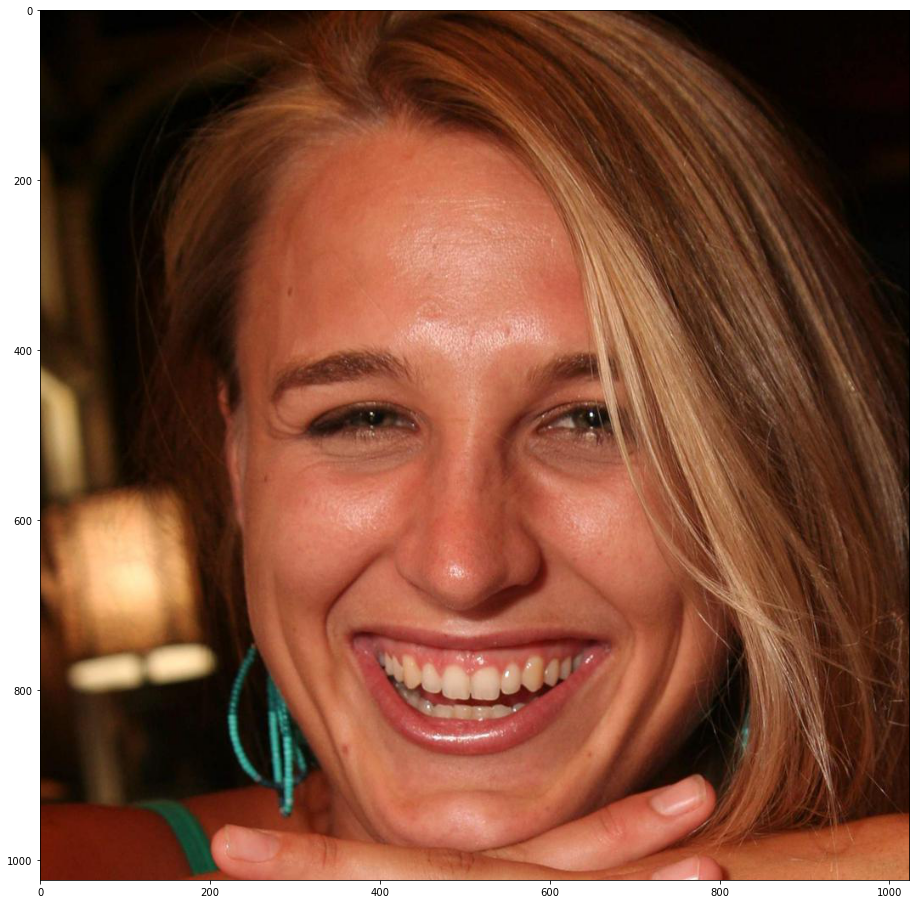

In [15]:
# Load a random image from the images folder
# file_name = random.choice(os.listdir(IMAGE_DIR))
file_name = "00001.png"
image = skimage.io.imread(os.path.join(IMAGE_DIR, file_name))

import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
plt.imshow(image)

# Prediction

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


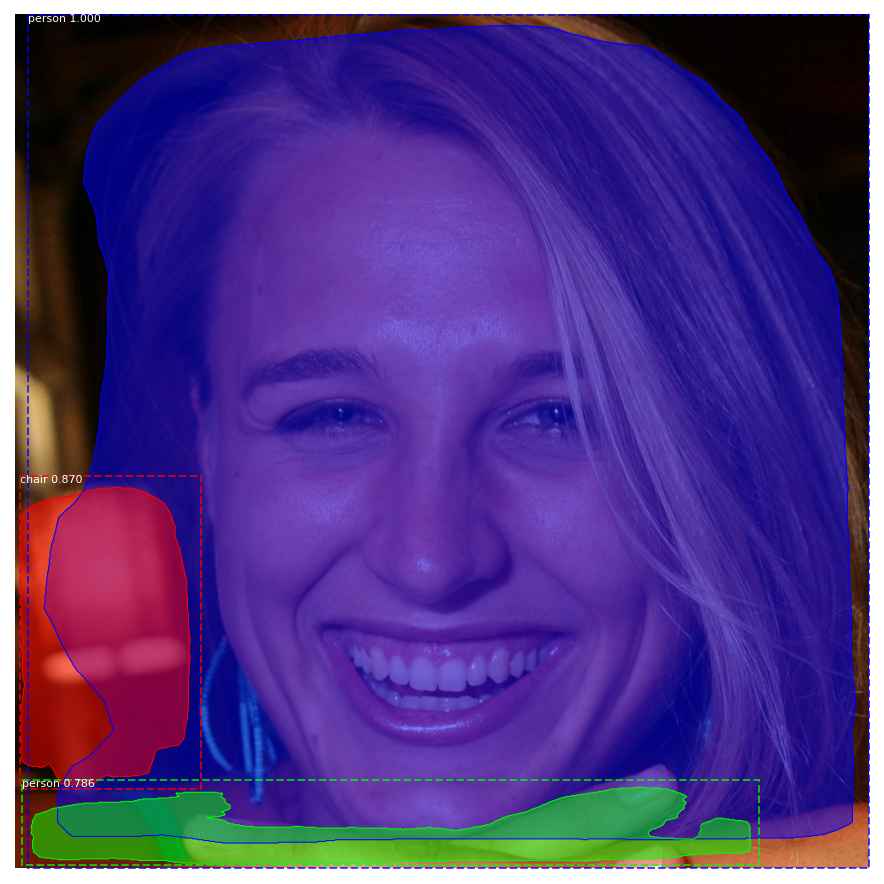

Total detected objects - 3
Total unique objects - 2
--------------------------------
person - 2
chair - 1


In [16]:
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
from collections import Counter
print(f'Total detected objects - {len(r["class_ids"])}')
print(f'Total unique objects - {len(np.unique(r["class_ids"]))}')
print("--------------------------------")
bla = [print(f'{class_names[id]} - {num}') for id,num in Counter(r['class_ids']).items()]

# Showing Masks

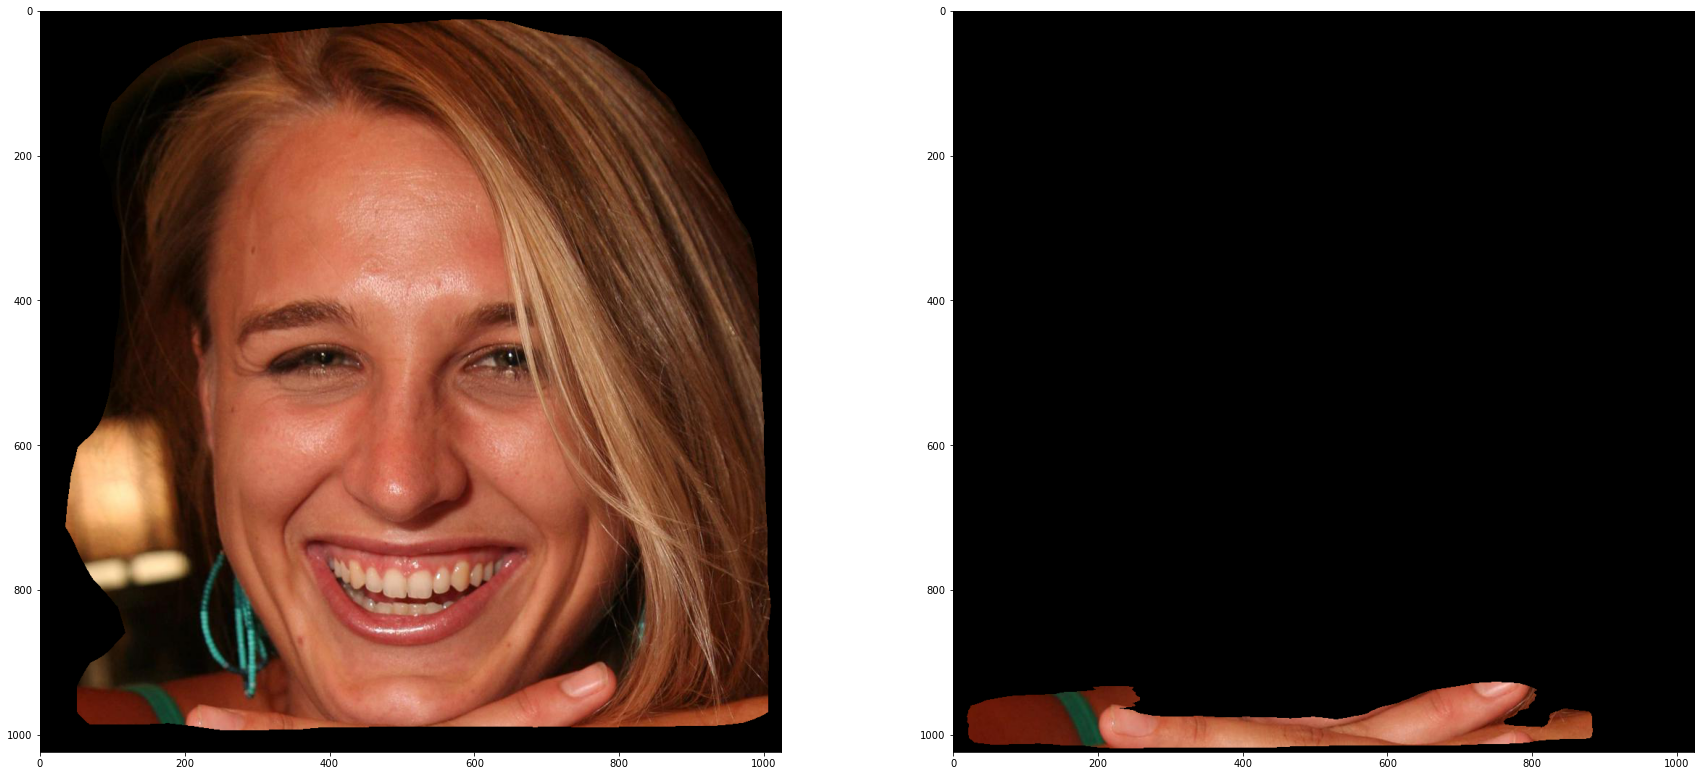

In [17]:
import matplotlib.pyplot as plt
ids = np.where(r['class_ids']==class_names.index("person"))[0]
ids = ids if(len(ids)<6) else ids[:10]
plt.figure(figsize=(30,30))
columns = 2
for i, id in enumerate(ids):
    mask = r['masks'][:, :, id] * 1
    mask =np.moveaxis(np.stack([mask, mask, mask]), 0, 2)
    masked_image = image * mask
    plt.subplot(len(ids) / columns + 1, columns, i + 1)
    plt.imshow(masked_image)

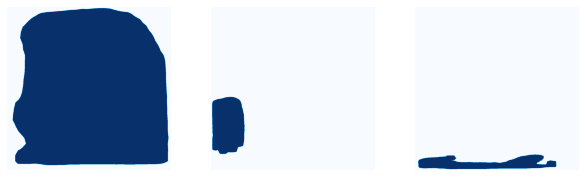

In [18]:
from mrcnn.visualize import display_images
import mrcnn.model as modellib
display_images(np.transpose(r['masks'], [2, 0, 1]), cmap="Blues")

# Save outputs

In [ ]:
import matplotlib.pyplot as plt
import cv2
import shutil
from datetime import datetime
out_dir = os.path.join(ROOT_DIR, "outputs/mask/" + str(datetime.now())[:-10].replace(":", "_"))
if not os.path.exists(out_dir): os.makedirs(out_dir)
else: 
    shutil.rmtree(out_dir)
    os.makedirs(out_dir)
for i, id in enumerate(r['class_ids']):
    mask = r['masks'][:, :, i] * 1
    mask =np.moveaxis(np.stack([mask, mask, mask]), 0, 2)
    masked_image = image * mask
    bla = cv2.imwrite(f'{out_dir}/{i+1}_{class_names[id]}.jpg', masked_image)